<a href="https://colab.research.google.com/github/Dowell-Lab/psea/blob/main/notebook_example/one_comorbid_many_gene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages we will use

In [63]:
import pandas as pd
import plotly.express as px
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# read in the files we will look at

In [2]:
url="https://raw.githubusercontent.com/Dowell-Lab/psea/refs/heads/main/testdata/psea_scores_20240923-152820.adjpval.csv"
df = pd.read_csv(url, index_col=0)
url2="https://raw.githubusercontent.com/Dowell-Lab/psea/refs/heads/main/testdata/genes.csv"
genedf = pd.read_csv(url2, index_col=0)

In [3]:
genedf["value"]=genedf["gene_id"]

In [4]:
#this brings in the medical disorders for all the individuals with Trisomy 21 in the Human Trisome Project
url = "https://raw.githubusercontent.com/Dowell-Lab/psea/refs/heads/main/testdata/comorbid_file.csv"
comorbid_df = pd.read_csv(url, index_col=0)



In [5]:
#This brings in the normalized counts for all the individuals with Trisomy 21 in the Human Trisome Project. These are not the real count data but are similar to reall count data.
#df=pd.read_csv('/content/drive/MyDrive/normcounts.csv')
url_counts="https://media.githubusercontent.com/media/Dowell-Lab/psea/refs/heads/main/testdata/value_expression_large.csv"
gene_exp_df=pd.read_csv(url_counts, index_col=0)



# Create a data frame of each gene linked to a comorbid

In [6]:
def acomorbidanditsgenes(acomorbid, gene_exp_df, comorbid_df, df, genedf, cuttoff=0.1, adjpvalcol="p_value_BenjaminiHochberg"):
  df_nona = df.dropna()
  df_nona_threshold = df_nona[df_nona[adjpvalcol]<cuttoff]
  df_nona_threshold_names = df_nona_threshold.merge(genedf, how ="inner", on="value")
  aconditiondf = df_nona_threshold_names[df_nona_threshold_names["binary_attribute"]==acondition]
  aconditiondf = aconditiondf.sort_values(["NES"])
  geneensmbllist = sorted(aconditiondf["value"].to_list())
  patientgenesexpdf = gene_exp_df[geneensmbllist+["Patient"]]
  onecomborbiddf = comorbid_df[[acomorbid, "Patient"]]
  merge_df = onecomborbiddf.merge(patientgenesexpdf, on="Patient")
  return merge_df


def splitdf_high_low_genes(thisdf, acondition, df,cuttoff=0.1, adjpvalcol="p_value_BenjaminiHochberg"):
  df_nona = df.dropna()
  df_nona_threshold = df_nona[df_nona[adjpvalcol]<cuttoff]
  df_nona_threshold_names = df_nona_threshold.merge(genedf, how ="inner", on="value")
  aconditiondf = df_nona_threshold_names[df_nona_threshold_names["binary_attribute"]==acondition]
  aconditiondf = aconditiondf.sort_values(["NES"])
  highgenes = aconditiondf[aconditiondf["NES"]<0]["value"].to_list()
  lowgenes = aconditiondf[aconditiondf["NES"]>0]["value"].to_list()
  merged_df = thisdf[[acondition, "Patient"]+highgenes+lowgenes]
  return merged_df

def splitpeoplewithandwithout(acomorbid, adfofexpressionandcomorbid):
  withcomorid = adfofexpressionandcomorbid[adfofexpressionandcomorbid[acomorbid]==1].copy()
  without_comorid = adfofexpressionandcomorbid[adfofexpressionandcomorbid[acomorbid]==0].copy()
  withcomorid = withcomorid.drop(columns=["Patient", acomorbid])
  without_comorid = without_comorid.drop(columns=["Patient", acomorbid])
  return withcomorid, without_comorid

def zscoregenes(acomorbid, genexpconditiondf):
    dontuse_columns = ["Patient", acomorbid]
    gene_names = [thiscolname for thiscolname in genexpconditiondf.columns if thiscolname not in dontuse_columns]
    #df.apply(zscore)
    transpose_df = genexpconditiondf.drop(columns=dontuse_columns)
    transpose_df = transpose_df.apply(zscore)
    transpose_df["Patient"] = genexpconditiondf["Patient"]
    transpose_df[acomorbid] = genexpconditiondf[acomorbid]
    transpose_df = transpose_df[["Patient", acomorbid]+gene_names]
    return transpose_df


# Pick a binary_attribute to look at

In [73]:
#acondition = "constipation_disorder"
acondition = "strabismus"
#acondition="eustachian_tube_disorder"
genexpconditiondf = acomorbidanditsgenes(acondition,gene_exp_df, comorbid_df, df, genedf)
#zscore_genexpconditiondf = zscoregenes(acondition, genexpconditiondf)
#lookatdf= splitdf_high_low_genes(zscore_genexpconditiondf, acondition, df)
lookatdf=genexpconditiondf
dontuse_columns = ["Patient", acondition]
gene_names = [thiscolname for thiscolname in lookatdf.columns if thiscolname not in dontuse_columns]
lookatdf = lookatdf.sort_values(gene_names[0])



In [74]:
from sklearn import cluster


#I should really be scaling useing scaled_df = StandardScaler().fit_transform(df)
#But that would take a while, so I'm using the zscored one...
#problem is the genes with the highest varience drive the order then

#data = lookatdf.drop(columns = ["Patient", acondition])
#k_means = cluster.KMeans(n_clusters=5, max_iter=50, random_state=1)
#k_means.fit(data)
#labels = k_means.labels_
#whichcluster = pd.DataFrame(labels, index=lookatdf.Patient, columns=['Cluster_ID'])
#whichcluster.reset_index(inplace=True)
#lookatdf = lookatdf.merge(whichcluster, on="Patient")
#lookatdf = lookatdf.sort_values(["Cluster_ID"])
#lookatdf = lookatdf.drop(columns=["Cluster_ID"])
wco, woco = splitpeoplewithandwithout(acondition, lookatdf)
wco.reset_index(inplace=True, drop=True)
woco.reset_index(inplace=True, drop=True)

In [75]:
fig = px.imshow(wco)
fig.update_traces(zmax=6, zmin=-6)
fig.show()

In [76]:
fig = px.imshow(woco)
fig.update_traces(zmax=6, zmin=-6)
fig.show()

In [77]:
feature_cols = gene_names
#scale the gene expression
scaler = MinMaxScaler()
lookatdf[feature_cols] = scaler.fit_transform(lookatdf[feature_cols])
#split to gene expression and condition we are trying tp predict
X = lookatdf[feature_cols] # Features
y = lookatdf[acondition] # Target variable


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1) # 70% training and 30% test


In [79]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)



In [80]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print (tn, fp, fn, tp )

110 4 10 3


In [81]:
# Model Accuracy, how often is the classifier correct?
print("accuracy_score:",metrics.accuracy_score(y_test, y_pred))
print("average_precision_score:",metrics.average_precision_score(y_test, y_pred))
print("balanced_accuracy_score:",metrics.balanced_accuracy_score(y_test, y_pred))

precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


accuracy_score: 0.889763779527559
average_precision_score: 0.17764125638141384
balanced_accuracy_score: 0.5978407557354926
precision: [0.91666667 0.42857143]
recall: [0.96491228 0.23076923]
fscore: [0.94017094 0.3       ]
support: [114  13]


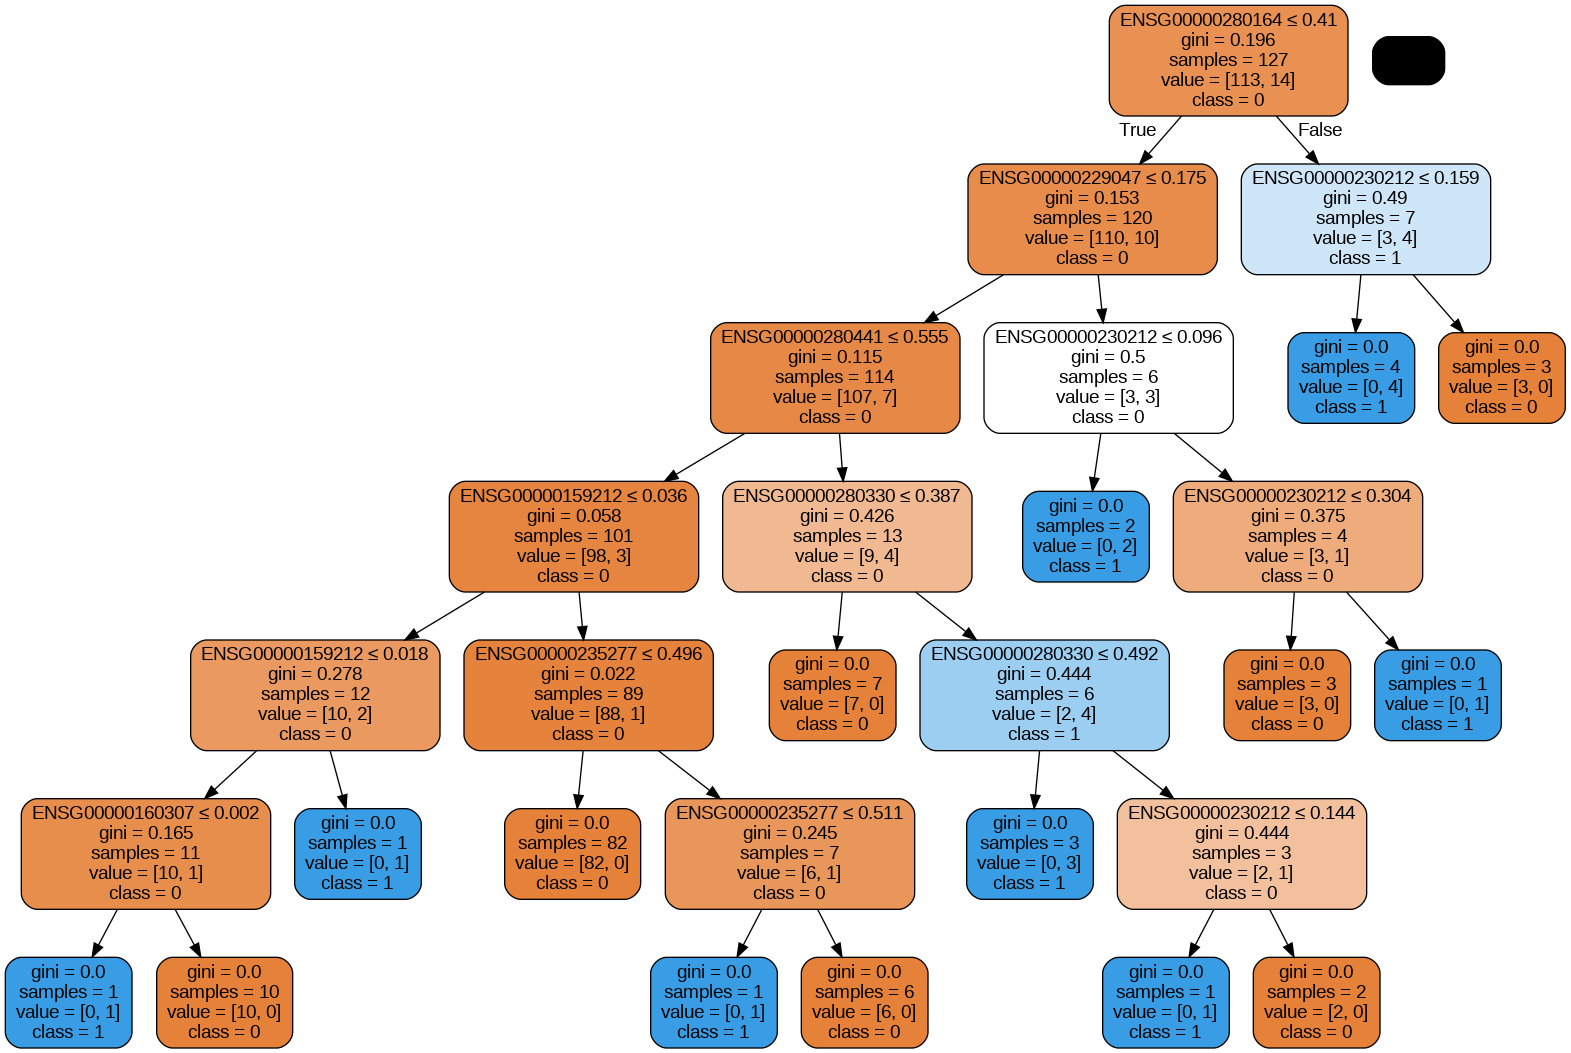

In [82]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(acondition+'_DecisionTreeClassifier.png')
Image(graph.create_png())


In [87]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10],
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20, 100]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [88]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')